# Paradigm 03: Agile Sprints Research Agent

This notebook implements the **Agile ResearchOps** paradigm from the Research Paradigms document.

## Core Concept

The Agile approach transforms the agent from an open-loop system to a closed-loop control system with:
- **Sprint-based execution**: Time-boxed research iterations
- **Retrospective reflection**: Course correction after each sprint
- **Backlog management**: Dynamic re-prioritization of research questions

## Literature Validation

> "Search-o1, R1-Searcher, DeepResearcher, WebDancer... exemplify this paradigm through iterative cycles of explicit reasoning, action, and reflection, aligning with the ReAct framework." —[Survey-3]

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [1]:
import os
import operator
import asyncio
from pathlib import Path
from typing import List, Annotated, TypedDict, Literal

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [2]:
# Initialize LLM and Tavily client
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
tavily_client = TavilyClient()

# Sprint configuration
MAX_SPRINTS = 3
SEARCHES_PER_SPRINT = 5
MAX_TOKENS_PER_SPRINT = 15000  # ~50k total budget

print(f"Using model: {MODEL_NAME}")
print(f"Max sprints: {MAX_SPRINTS}")
print(f"Searches per sprint: {SEARCHES_PER_SPRINT}")

Using model: gpt-5-mini-2025-08-07
Max sprints: 3
Searches per sprint: 5


## 2. State Definitions

In [3]:
class ResearchQuestion(BaseModel):
    """A research question in the backlog."""
    question: str = Field(description="The research question to investigate")
    priority: int = Field(default=1, description="Priority level (1=highest)")
    status: str = Field(default="pending", description="pending, in_progress, or completed")

class SprintFinding(BaseModel):
    """A finding from a sprint."""
    question: str = Field(description="The question this finding addresses")
    finding: str = Field(description="The key finding or insight")
    sources: List[str] = Field(default_factory=list, description="Source URLs")

class RetrospectiveOutput(BaseModel):
    """Output from the retrospective analysis."""
    what_we_learned: str = Field(description="Key learnings from this sprint")
    what_is_still_unclear: str = Field(description="Gaps or uncertainties remaining")
    should_continue: bool = Field(description="Whether to continue with another sprint")
    updated_priorities: List[str] = Field(description="Re-prioritized questions for next sprint")

In [4]:
class AgileResearchState(TypedDict):
    """State for the Agile Research Agent."""
    # Input
    question: str

    # Sprint management - NOTE: backlog is NOT an accumulator, it gets replaced each sprint
    backlog: List[str]  # Research questions to investigate (replaced, not accumulated)
    current_sprint: int
    max_sprints: int

    # Findings accumulator (these DO accumulate across sprints)
    sprint_findings: Annotated[List[str], operator.add]  # Findings from all sprints
    source_urls: Annotated[List[str], operator.add]  # Track all sources for citation

    # Retrospective notes
    retrospective_notes: Annotated[List[str], operator.add]
    findings_summary: str  # Compressed summary to avoid token bloat
    should_terminate_early: bool  # NEW: Flag from retrospective to stop early

    # Output
    final_report: str

## 3. Node Functions

In [5]:
# Prompts
PLAN_BACKLOG_PROMPT = """You are a research planning expert. Given a research question, 
decompose it into 4-6 specific sub-questions that need to be investigated.

Research Question: {question}

Generate a prioritized list of specific, focused research questions that together will answer the main question.
Each question should be independently searchable and cover a different aspect.

Return your response as a numbered list (highest priority first):
1. [Most critical sub-question]
2. [Second priority sub-question]
...
"""

SPRINT_RESEARCH_PROMPT = """You are a research agent conducting Sprint {sprint_num} of {max_sprints}.

Current research focus: {current_question}

Based on the search results below, extract the key findings that address the research question.
Be specific and cite sources with URLs where relevant.

Search Results:
{search_results}

Provide a comprehensive summary of findings (400-600 words). Include specific facts, statistics, and source URLs.
"""

SUMMARIZE_FINDINGS_PROMPT = """Summarize the key findings from the research sprints so far into a concise format.

All Findings:
{all_findings}

Create a bullet-point summary (max 500 words) capturing:
- Key facts and statistics discovered
- Main themes and patterns
- Important sources cited
- Any contradictions or debates identified

Be concise but preserve critical information.
"""

RETROSPECTIVE_PROMPT = """You are conducting a sprint retrospective for a research project.

Original Question: {original_question}

Sprint {sprint_num} of {max_sprints} has completed.

Summary of findings so far:
{findings_summary}

Current remaining questions in backlog:
{remaining_backlog}

Analyze the progress and provide a STRUCTURED response:

## LEARNINGS
What key insights did we gain this sprint?

## GAPS
What is still unclear or needs more investigation?

## CONTINUE
Should we continue with another sprint? Answer YES or NO with brief justification.

## NEW_QUESTIONS
List any NEW questions that emerged from our research (or "None" if none):
- [New question 1]
- [New question 2]

## REPRIORITIZED_BACKLOG
Reorder the remaining questions by priority, incorporating any new questions:
1. [Highest priority question]
2. [Next priority]
...

Be honest about gaps and uncertainties. Focus on what will most help answer the original question.
"""

FINAL_REPORT_PROMPT = """You are a senior research analyst writing a final report.

Original Question: {original_question}

All Research Findings:
{all_findings}

Retrospective Insights:
{retrospective_notes}

Source URLs used:
{source_urls}

Write a comprehensive research report that:
1. Directly answers the original question with evidence
2. Synthesizes findings across all sprints into coherent analysis
3. Acknowledges any remaining uncertainties or limitations
4. Includes inline citations with source URLs

The report should be well-structured with clear sections and approximately 1000-1500 words.
"""

In [6]:
def search_web(query: str, max_results: int = 5) -> tuple[str, List[str]]:
    """Execute web search using Tavily. Returns (formatted_results, list_of_urls)."""
    try:
        # Truncate query if too long (Tavily limit)
        if len(query) > 400:
            query = query[:400]

        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )

        results = []
        urls = []

        if response.get("answer"):
            results.append(f"Summary: {response['answer']}")

        for r in response.get("results", []):
            url = r.get('url', 'N/A')
            urls.append(url)
            results.append(f"- {r.get('title', 'No title')}: {r.get('content', '')[:500]}... (Source: {url})")

        return "\n\n".join(results), urls
    except Exception as e:
        return f"Search error: {str(e)}", []

In [7]:
async def plan_backlog(state: AgileResearchState) -> dict:
    """Plan the initial research backlog by decomposing the question."""
    question = state["question"]
    
    prompt = PLAN_BACKLOG_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    # Parse numbered list from response
    lines = response.content.strip().split("\n")
    backlog = []
    for line in lines:
        line = line.strip()
        if line and (line[0].isdigit() or line.startswith("-")):
            # Remove numbering and clean up
            clean = line.lstrip("0123456789.-) ").strip()
            if clean:
                backlog.append(clean)
    
    print(f"Created backlog with {len(backlog)} research questions")
    
    return {
        "backlog": backlog,
        "current_sprint": 1,
        "max_sprints": MAX_SPRINTS
    }

In [8]:
async def execute_sprint(state: AgileResearchState) -> dict:
    """Execute a research sprint on the current backlog item."""
    backlog = state.get("backlog", [])
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", MAX_SPRINTS)

    if not backlog:
        return {"sprint_findings": ["No questions in backlog to research."]}

    # Get current question (first in backlog)
    current_question = backlog[0]
    print(f"\n{'='*60}")
    print(f"Sprint {current_sprint}/{max_sprints}: {current_question[:80]}...")
    print(f"{'='*60}")

    # Execute searches
    search_results = []
    all_urls = []
    queries = [current_question]  # Main query

    # Generate additional search queries for depth
    if SEARCHES_PER_SPRINT > 1:
        query_prompt = f"""Generate {SEARCHES_PER_SPRINT - 1} specific web search queries to investigate this question from different angles:
        Question: {current_question}

        Return only the search queries, one per line."""
        query_response = await llm.ainvoke([HumanMessage(content=query_prompt)])
        additional_queries = [q.strip() for q in query_response.content.split("\n") if q.strip()]
        queries.extend(additional_queries[:SEARCHES_PER_SPRINT - 1])

    # Execute all searches
    for query in queries:
        print(f"  Searching: {query[:60]}...")
        result, urls = search_web(query)
        search_results.append(result)
        all_urls.extend(urls)

    combined_results = "\n\n---\n\n".join(search_results)

    # Synthesize findings
    synthesis_prompt = SPRINT_RESEARCH_PROMPT.format(
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        current_question=current_question,
        search_results=combined_results
    )

    synthesis = await llm.ainvoke([HumanMessage(content=synthesis_prompt)])

    finding = f"## Sprint {current_sprint} Findings: {current_question}\n\n{synthesis.content}"
    print(f"  Synthesized {len(synthesis.content)} characters of findings")
    print(f"  Collected {len(all_urls)} source URLs")

    # Remove processed question from backlog (backlog is NOT an accumulator, so this replaces it)
    updated_backlog = backlog[1:] if len(backlog) > 1 else []

    return {
        "sprint_findings": [finding],
        "source_urls": all_urls,
        "backlog": updated_backlog  # This REPLACES the backlog since it's not an Annotated accumulator
    }

In [9]:
import re

async def summarize_findings(all_findings: str) -> str:
    """Summarize findings to manage token budget."""
    if len(all_findings) < 2000:
        return all_findings  # No need to summarize if short

    prompt = SUMMARIZE_FINDINGS_PROMPT.format(all_findings=all_findings[:8000])
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    return response.content


def parse_reprioritized_backlog(response_content: str) -> List[str]:
    """Parse the reprioritized backlog from retrospective output."""
    # Look for the REPRIORITIZED_BACKLOG section
    backlog_match = re.search(
        r'## REPRIORITIZED_BACKLOG\s*(.*?)(?=##|$)',
        response_content,
        re.DOTALL | re.IGNORECASE
    )

    if not backlog_match:
        # Fallback: look for numbered list at the end
        backlog_match = re.search(r'(?:backlog|priority).*?:\s*((?:\d+\..*?\n?)+)', response_content, re.DOTALL | re.IGNORECASE)

    if backlog_match:
        backlog_text = backlog_match.group(1)
        # Parse numbered list
        questions = []
        for line in backlog_text.strip().split("\n"):
            line = line.strip()
            if line and (line[0].isdigit() or line.startswith("-")):
                clean = re.sub(r'^[\d\.\-\)\s]+', '', line).strip()
                if clean and len(clean) > 10:  # Filter out too-short items
                    questions.append(clean)
        return questions

    return []


def parse_should_continue(response_content: str) -> bool:
    """Parse whether the retrospective recommends continuing.
    
    Handles various negative phrasings:
    - "NO" / "No" / "no"
    - "Not at this time" / "Not necessary"
    - "Negative"
    - "We should stop"
    - "No need to continue"
    """
    # Look for CONTINUE section
    continue_match = re.search(
        r'## CONTINUE\s*(.*?)(?=##|$)',
        response_content,
        re.DOTALL | re.IGNORECASE
    )
    
    if continue_match:
        continue_text = continue_match.group(1).strip().lower()
        
        # Check for negative patterns (more comprehensive)
        negative_patterns = [
            r'^no\b',           # Starts with "no" (word boundary)
            r'^not\b',          # Starts with "not" (not necessary, not at this time)
            r'^negative',       # Starts with "negative"
            r'should\s+stop',   # "should stop"
            r'should\s+not\s+continue',  # "should not continue"
            r'no\s+need',       # "no need to continue"
            r'sufficient',      # "question is sufficiently answered"
            r'adequately\s+answered',  # "adequately answered"
            r'fully\s+answered',  # "fully answered"
        ]
        
        for pattern in negative_patterns:
            if re.search(pattern, continue_text):
                return False  # Don't continue
    
    # Default to continuing if no clear negative signal
    return True


async def retrospective(state: AgileResearchState) -> dict:
    """Conduct retrospective analysis after sprint with dynamic backlog re-prioritization."""
    original_question = state["question"]
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", MAX_SPRINTS)
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    remaining_backlog = state.get("backlog", [])

    # Summarize findings to manage token budget
    findings_summary = await summarize_findings(all_findings)

    prompt = RETROSPECTIVE_PROMPT.format(
        original_question=original_question,
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        findings_summary=findings_summary,
        remaining_backlog="\n".join(f"- {q}" for q in remaining_backlog) if remaining_backlog else "None - all initial questions addressed"
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    # Parse the reprioritized backlog from the response
    reprioritized_backlog = parse_reprioritized_backlog(response.content)
    
    # Parse whether to continue
    should_continue = parse_should_continue(response.content)

    # If parsing failed, fall back to existing backlog
    if not reprioritized_backlog and remaining_backlog:
        reprioritized_backlog = remaining_backlog
        print(f"  Retrospective: Using existing backlog (parsing failed)")
    else:
        print(f"  Retrospective: Reprioritized to {len(reprioritized_backlog)} questions")
    
    if not should_continue:
        print(f"  Retrospective: Recommends STOPPING early (question sufficiently answered)")

    retro_note = f"### Sprint {current_sprint} Retrospective\n\n{response.content}"

    return {
        "retrospective_notes": [retro_note],
        "current_sprint": current_sprint + 1,
        "backlog": reprioritized_backlog,  # REPLACE with reprioritized backlog
        "findings_summary": findings_summary,  # Store for next retrospective
        "should_terminate_early": not should_continue  # Set termination flag
    }

In [10]:
def should_continue_sprinting(state: AgileResearchState) -> Literal["execute_sprint", "write_report"]:
    """Decide whether to continue with another sprint or write the final report."""
    current_sprint = state.get("current_sprint", 1)
    max_sprints = state.get("max_sprints", MAX_SPRINTS)
    backlog = state.get("backlog", [])
    should_terminate_early = state.get("should_terminate_early", False)
    
    # Stop conditions:
    # 1. Reached max sprints
    # 2. Backlog is empty
    # 3. Retrospective recommends early termination (question answered)
    if current_sprint > max_sprints:
        print(f"\nMax sprints ({max_sprints}) reached. Moving to final report.")
        return "write_report"
    
    if not backlog:
        print(f"\nBacklog empty after sprint {current_sprint - 1}. Moving to final report.")
        return "write_report"
    
    if should_terminate_early:
        print(f"\nRetrospective recommends early termination. Moving to final report.")
        return "write_report"
    
    print(f"\nContinuing to sprint {current_sprint}. {len(backlog)} questions remaining.")
    return "execute_sprint"

In [11]:
async def write_report(state: AgileResearchState) -> dict:
    """Write the final research report."""
    original_question = state["question"]
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    findings_summary = state.get("findings_summary", "")
    retrospective_notes = "\n\n".join(state.get("retrospective_notes", []))
    source_urls = list(set(state.get("source_urls", [])))  # Deduplicate

    # Token efficiency: use summary if findings are too long
    # Full findings can be 1800+ words with 3 sprints, which risks token limits
    if len(all_findings) > 6000 and findings_summary:
        print(f"  Using findings summary ({len(findings_summary)} chars) instead of full findings ({len(all_findings)} chars)")
        findings_for_report = findings_summary
    else:
        findings_for_report = all_findings
    
    # Also truncate retrospective notes if too long
    if len(retrospective_notes) > 3000:
        retrospective_notes = retrospective_notes[:3000] + "\n\n[... truncated for brevity ...]"

    prompt = FINAL_REPORT_PROMPT.format(
        original_question=original_question,
        all_findings=findings_for_report,
        retrospective_notes=retrospective_notes,
        source_urls="\n".join(source_urls[:30])  # Limit to top 30 sources
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    print(f"\nFinal report generated: {len(response.content)} characters")
    print(f"Sources used: {len(source_urls)} unique URLs")

    return {
        "final_report": response.content
    }

## 4. Graph Construction

In [12]:
# Build the Agile Research Agent graph
agile_builder = StateGraph(AgileResearchState)

# Add nodes
agile_builder.add_node("plan_backlog", plan_backlog)
agile_builder.add_node("execute_sprint", execute_sprint)
agile_builder.add_node("retrospective", retrospective)
agile_builder.add_node("write_report", write_report)

# Add edges
agile_builder.add_edge(START, "plan_backlog")
agile_builder.add_edge("plan_backlog", "execute_sprint")
agile_builder.add_edge("execute_sprint", "retrospective")

# Conditional edge: continue sprinting or write report
agile_builder.add_conditional_edges(
    "retrospective",
    should_continue_sprinting,
    {
        "execute_sprint": "execute_sprint",
        "write_report": "write_report"
    }
)

agile_builder.add_edge("write_report", END)

# Compile
agile_graph = agile_builder.compile()

print("Agile Research Agent compiled successfully")

Agile Research Agent compiled successfully


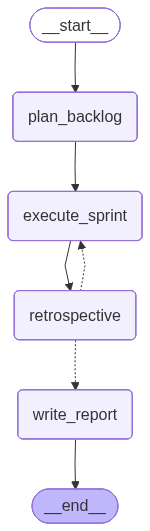

In [13]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(agile_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 5. Agent Wrapper for Evaluation

In [16]:
async def agile_sprints_agent_async(inputs: dict) -> dict:
    """
    Async version of the Agile Sprints research agent.
    Use this version when calling from Jupyter notebooks.
    """
    question = inputs.get("question", "")

    result = await agile_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 50}
    )

    return {
        "output": result.get("final_report", ""),
        "sprint_findings": result.get("sprint_findings", []),
        "retrospective_notes": result.get("retrospective_notes", []),
        "source_urls": list(set(result.get("source_urls", []))),  # Deduplicated URLs
        "num_sprints": result.get("current_sprint", 1) - 1  # Actual sprints completed
    }


def agile_sprints_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Agile Sprints research agent.

    Compatible with evaluation harness.

    Args:
        inputs: Dictionary with 'question' key

    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")

    async def _execute():
        return await agile_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 50}
        )

    # Check if we're already in an async context (e.g., Jupyter notebook)
    try:
        loop = asyncio.get_running_loop()
        # We're in an event loop - need to run in a separate thread
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        # No event loop running, safe to use asyncio.run
        result = asyncio.run(_execute())

    return {
        "output": result.get("final_report", ""),
        "sprint_findings": result.get("sprint_findings", []),
        "retrospective_notes": result.get("retrospective_notes", []),
        "source_urls": list(set(result.get("source_urls", []))),  # Deduplicated URLs
        "num_sprints": result.get("current_sprint", 1) - 1  # Actual sprints completed
    }

## 6. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [17]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Agile Sprints Agent with question:\n{test_question}\n")
print("Running sprint-based research (this may take several minutes)...\n")

try:
    # Use the async version in notebooks to avoid event loop conflicts
    result = await agile_sprints_agent_async({"question": test_question})

    print("=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Sprints completed: {result.get('num_sprints', 'N/A')}")
    print(f"Sprint findings collected: {len(result.get('sprint_findings', []))}")
    print(f"Retrospectives conducted: {len(result.get('retrospective_notes', []))}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    print("Agent test PASSED")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing Agile Sprints Agent with question:
What are the key benefits and challenges of using large language models in enterprise applications?

Running sprint-based research (this may take several minutes)...

Created backlog with 6 research questions

Sprint 1/3: What measurable business benefits (productivity gains, cost savings, revenue imp...
  Searching: What measurable business benefits (productivity gains, cost ...
  Searching: enterprise ROI of large language models quantified "producti...
  Searching: LLM deployment case study customer support "handle time" "fi...
  Searching: methodology to measure ROI of LLMs "KPIs" "productivity metr...
  Searching: developer productivity large language models "GitHub Copilot...
  Synthesized 4839 characters of findings
  Collected 25 source URLs
  Retrospective: Reprioritized to 20 questions

Continuing to sprint 2. 20 questions remaining.

Sprint 2/3: What are the principal data privacy, security, and compliance risks (including d...
  Se

## 7. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

### 7.1 Full Evaluation

This runs the complete evaluation on all 20 questions.

**⚠️ WARNING:** This is expensive and time-consuming!
- **Expected runtime:** 1-2 hours
- Single run to reduce cost

In [ ]:
# Full Evaluation on All 20 Questions
# ⚠️ EXPENSIVE - Only uncomment when ready for full evaluation
# Uncomment to run:

# # Define comprehensive evaluator suite
# evaluators = [
#     fact_recall,              # Required facts coverage
#     citation_precision,       # Citation URL validity
#     minimum_sources_check,    # Minimum source count
#     coherence_judge,          # Logical structure
#     depth_judge,              # Analysis depth
#     relevance_judge,          # Addresses question
# ]
# 
# # Run full evaluation
# print("Starting FULL evaluation on all 20 questions...")
# print("Agile Sprints Agent - this will take 1-2 hours.")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=agile_sprints_agent,
#     evaluators=evaluators,
#     experiment_name="agile_sprints_v1",
#     monte_carlo_runs=1,  # Single run to reduce cost
#     max_concurrency=2,   # Lower concurrency for stability
#     description="Agile Sprints paradigm evaluation on all difficulty tiers"
# )
# 
# # Display comprehensive results
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Runs per question: {results.num_runs}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")
# 
# # Save results to file
# import json
# from datetime import datetime
# 
# results_file = Path("../results") / f"agile_sprints_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# results_file.parent.mkdir(exist_ok=True)
# 
# with open(results_file, 'w') as f:
#     json.dump({
#         "experiment_name": results.experiment_name,
#         "num_questions": results.num_questions,
#         "num_runs": results.num_runs,
#         "metrics": results.metrics,
#         "per_question": results.per_question_results
#     }, f, indent=2)
# 
# print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")

### 7.2 Viewing Results in LangSmith

After running an evaluation, you can view detailed results in the LangSmith UI:

1. Go to https://smith.langchain.com
2. Navigate to your project (`deep_research_new`)
3. Click on "Datasets" to see your test dataset
4. Click on "Experiments" to see evaluation runs
5. Compare Agile Sprints vs Baseline results